In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Removing NaNs and outliers
All NaNs are in DER features or in PRI-leading features.
I removed all DER features and also PRI-leading features (although not all of DER features them contain null values)


In [2]:
#import the data
data = pd.read_csv('./data/train.csv.zip')
data.replace( -999., np.NaN, inplace=True)

#remove the columns containing missing values
#DER columns
der_headers = [x for x in data.columns if 'DER' in x]
#PRI columns containing lead
leading_pri_headers = [x for x in data.columns if 'leading' in x]
data.drop(columns=der_headers+leading_pri_headers, inplace = True)
data.isnull().sum()
print('After polishing data we have: \n features: ', len(data.columns) - 2, 'rows :', len(data))
data.head()

After polishing data we have: 
 features:  11 rows : 250000


,Id,Prediction,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_all_pt
0,100000,s,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,113.497
1,100001,b,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226
2,100002,b,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251
3,100003,b,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,0.000
4,100004,b,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,0.000


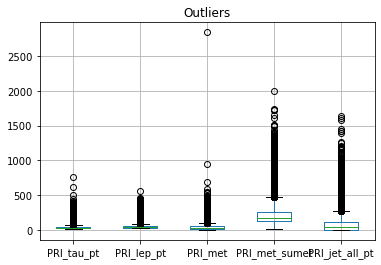

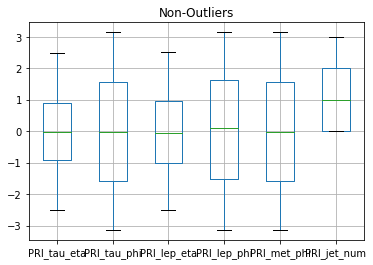

In [3]:
#normalize the data
normalized = data.drop(columns = ['Id', 'Prediction'])
(normalized-normalized.mean())/normalized.std()

#look for outliers 
outliers = ['PRI_tau_pt', 'PRI_lep_pt', 'PRI_met', 'PRI_met_sumet', 'PRI_jet_all_pt']
non_outliers = list(normalized.columns)
for x in outliers: non_outliers.remove(x)

#ouliers
fig = plt.figure()
ax = normalized.boxplot(column=outliers, figsize = (7.5, 10))
ax.set_title('Outliers')

#non outliers
fig = plt.figure()
ax = normalized.boxplot(column=non_outliers, figsize = (7.5, 10))
_ = ax.set_title('Non-Outliers')

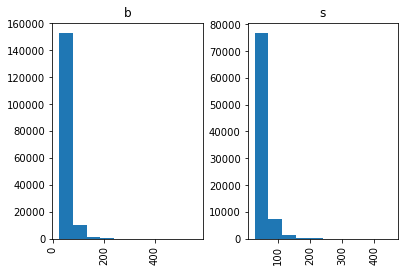

In [4]:
#Is being an outlier indicative of the Prediction? Apparently not (the distribution does not change)
selector = 1
_ = data[['Prediction',outliers[selector]]].hist(by = 'Prediction')

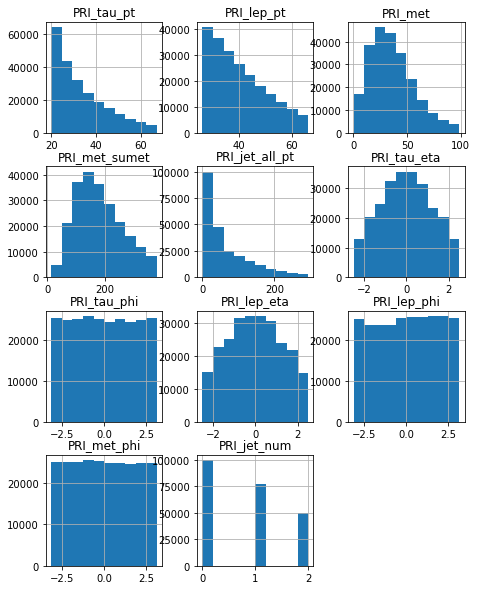

In [5]:
#plot the distributions w/o the outliers 
_ = normalized[normalized < 3*normalized.std()][outliers+non_outliers].hist(figsize=(7.5, 10))

In [ ]:
_ = pd.plotting.scatter_matrix(data, alpha=0.2)

# Correlations

## Overview
Turned the prediction into a +1 -1 variable and computed the correlations between the predicion and other features, to try to spot the most relevant features. 

How can we exploit features with a lot of missing points anyway ?? 

The data points w missing features are the same for most features

In [8]:
data = pd.read_csv('./data/train.csv.zip')
data.replace( -999., np.NaN, inplace=True)

data.Prediction = 2*(data.Prediction == 'b')-1
data.Prediction.sort_values(ascending = True)

#compute relevat metrics on features
feature_score = data.corr()['Prediction'].abs().sort_values(ascending = False).drop(['Id', 'Prediction'])
features_nan = (data.isna().drop(columns=['Id', 'Prediction']).sum()/float(len(data))*100).round(1)
features_outliers = (((data-data.mean())/data.std() > 3.).sum() / data.count().astype(float)*100.).drop(['Prediction', 'Id'])
print('Check: ', set(list(feature_score.index)) ==  set(list(features_nan.index)), set(list(feature_score.index)) ==  set(list(features_outliers.index)))

#create dataset w features metrics
features = pd.concat([feature_score, features_outliers.round(2), features_nan], axis = 1, )
features.columns = pd.Index(['Score', 'Outliers_percentage', 'Nan_percentage'])
print(features[['Score', 'Nan_percentage', 'Outliers_percentage']].sort_values('Score', ascending=False))


Check:  True True
                                Score  Nan_percentage  Outliers_percentage
DER_mass_transverse_met_lep  0.351428             0.0                 0.74
DER_deltaeta_jet_jet         0.328305            71.0                 0.10
DER_mass_jet_jet             0.316727            71.0                 2.23
DER_lep_eta_centrality       0.308082            71.0                 0.00
DER_prodeta_jet_jet          0.294340            71.0                 0.43
DER_met_phi_centrality       0.271752             0.0                 0.00
PRI_tau_pt                   0.235238             0.0                 1.79
DER_pt_ratio_lep_tau         0.195398             0.0                 1.55
DER_pt_h                     0.192526             0.0                 1.92
DER_sum_pt                   0.153236             0.0                 1.87
PRI_met_sumet                0.135520             0.0                 1.62
PRI_jet_all_pt               0.134296             0.0                 1.82
PRI_jet

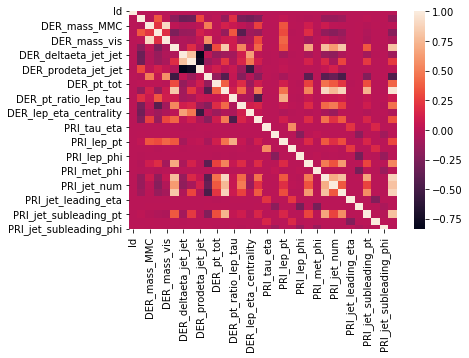

In [9]:
sns.heatmap(data.corr())

In [10]:
#compute the rand of the correlation matrix
np.linalg.matrix_rank(data.corr())

32

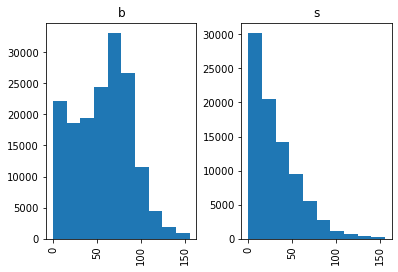

In [13]:
#"DER_mass_transverse_met_lep"  follows a different distribution when according with the prediction
temp = pd.read_csv('./data/train.csv.zip')
_ = temp[['Prediction', 'DER_mass_transverse_met_lep']][(data.DER_mass_transverse_met_lep - data.DER_mass_transverse_met_lep.mean())/data.DER_mass_transverse_met_lep.std() < 3.].hist(by = 'Prediction')

## Idea: can we introduce NaN as a category? See below

Text(0.5, 1.0, 'Histogram on NaN values')

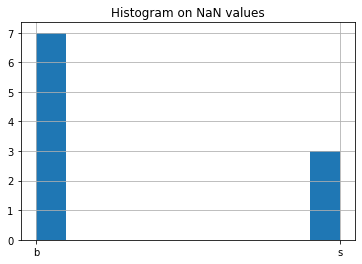

In [14]:
data = pd.read_csv('./data/train.csv.zip')
data.replace( -999., np.NaN, inplace=True)
ax = data[data['PRI_jet_subleading_pt'].isna()]['Prediction'].hist(density = 1)
ax.set_title('Histogram on NaN values')

## Look for correlated features

In [ ]:
#make a summary of the data
print('Unique indeces: ', data.index.is_unique)
print('We have ', len(data.columns),' fields')
print('We have ', len(data), 'instances.')
print('The following are very correlated fields:')

#look for correlations on data w/o outliers

threshold = 0.8
correlations = data[data -data.mean()/data.std() < 3].corr().corr()
correlations.values[np.tril_indices(len(correlations))] = 0.
print('We have ', (abs(correlations)>threshold).values.sum(), ' correlated quantities')

#print correlated quantities
correlated_quanties = []
for index, row in ((correlations - np.identity(len(correlations))) > threshold).iterrows():
    correlates_with = correlations.columns[np.where(row)].values.tolist()
    if correlates_with:
        for elem in correlates_with:
            correlated_quanties += [(index, elem)]
for c in correlated_quanties:
    print(c[0], '\t and \t', c[1], '\t corr: ', correlations[c[1]][c[0]])

Unique indeces:  True
We have  32  fields
We have  250000 instances.
The following are very correlated fields:
We have  5  correlated quantities
DER_pt_h 	 and 	 DER_pt_tot 	 corr:  0.987908711289022
DER_deltaeta_jet_jet 	 and 	 DER_lep_eta_centrality 	 corr:  0.8752987986526412
PRI_tau_eta 	 and 	 PRI_lep_eta 	 corr:  0.8360011467966758


In [ ]:
pd.concat([data.corr()['DER_pt_h'], data.corr()['DER_pt_tot']], axis = 1).corr()

,DER_pt_h,DER_pt_tot
DER_pt_h,1.000000,0.424824
DER_pt_tot,0.424824,1.000000


In [ ]:
data[['DER_pt_h', 'DER_pt_tot']].head(20)

,DER_pt_h,DER_pt_tot
0,27.980,41.928
5,116.344,61.619
6,106.130,2.545
11,30.816,36.745
23,174.075,6.663
27,144.766,0.367
29,132.806,23.290
31,198.114,31.017
32,63.165,6.580
33,39.901,9.732


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025AB12BA988>,
      dtype=object)

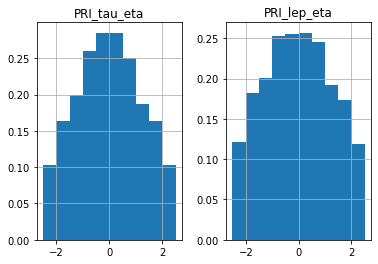

In [ ]:
data[data -data.mean()/data.std() < 3][['PRI_tau_eta', 'PRI_lep_eta']].hist(density = True)

# Other Random Plots

In [15]:
(data['DER_deltaeta_jet_jet'].isna() == data['DER_lep_eta_centrality'].isna()).all()

True

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA801F92C8>,
      dtype=object)

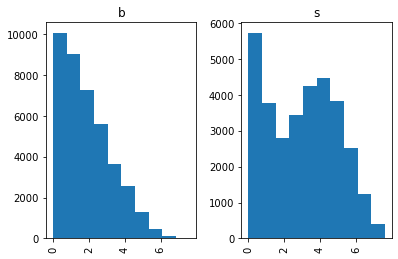

In [16]:
field = 'DER_deltaeta_jet_jet'
temp[['Prediction', field]][(data[field] - data[field].mean())/data[field].std() < 3.].hist(by = 'Prediction')

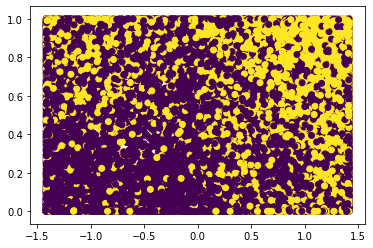

In [17]:
plt.scatter(data['DER_met_phi_centrality'], data['DER_lep_eta_centrality'].values, c= (data.Prediction == 's'))

In [18]:
data = pd.read_csv('./data/train.csv.zip')
data.replace( -999., np.NaN, inplace=True)

data.dropna(inplace = True)
print(len(data))

68114


(<matplotlib.collections.PathCollection at 0x1aa81065988>,)

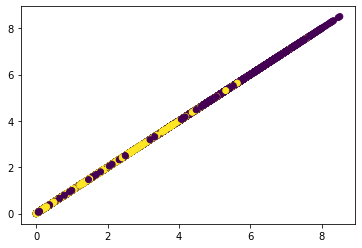

In [21]:
plt.scatter(data['DER_deltaeta_jet_jet'], data['DER_deltaeta_jet_jet'], c = (data['Prediction'] == 'b')), 